In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
import smfmodel as smm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='anndata')
warnings.filterwarnings("ignore", category=UserWarning, module='anndata')

# Below series of cells is run each time you want to generate new transition matrix solution set

In [2]:
### Generate solutions of transition matrices for the observed proportion sets derived from the HMM predictions ###

## Provide the observed proportions of states ##
# ORDER MATTERS #
# Order is: Both accessible, Promoter only accessible, Neither Accessible, and Enhancer only accessible.
observed_proportions_on = np.array([0.33, 0.19, 0.29, 0.19])
observed_proportions_off = np.array([0.10, 0.04, 0.53, 0.33])

## Define the variance threshold for a successful steady state solution of a transtion matrix ##
variance_threshold = np.array([0.07, 0.07, 0.08, 0.07])

transition_params = {
    "total_matrices": 10000, # Number of solution matrices to find.
    "size": 4, # Dimensions of the transition matrix (n x n).
    "allow_self_transitions": True, # Whether self-transtions can occur
    "constrain_transitions_to_adjacent": True # Whether to constrain transitions to only adjacent nodes.
}

## Solve for the solutions
transition_matrix_solutions_on = smm.mm.generate_transition_matrix_solutions(observed_proportions_on, variance_threshold, "Active Allele", transition_params)
transition_matrix_solutions_off = smm.mm.generate_transition_matrix_solutions(observed_proportions_off, variance_threshold, "Silent Allele", transition_params)


Generating 10000 matrices for Active Allele: 100%|█| 10000/10000 [00:21<00:00, 4
Generating 10000 matrices for Silent Allele: 100%|█| 10000/10000 [02:07<00:00, 7


In [3]:
### Compile transition matrix solutions from each allele into a single AnnData object ###

## The transition names corresponding to the flattened transition matrix
transition_names = ['Both-Both', 'Both-Promoter_only', 'Both-Neither', 'Both-Enhancer_only', 'Promoter_only-Both', 'Promoter_only-Promoter_only', 'Promoter_only-Neither', 'Promoter_only-Enhancer_only', 'Neither-Promoter_only', 'Neither-Both', 'neither-Neither', 'Neither-Enhancer_only', 'Enhancer_only-Both', 'Enhancer_only-Promoter_only', 'Enhancer_only-Neither', 'Enhancer_only-Enhancer_only']

# Load adata for each condition
adata_off = smm.mm.load_transitions_into_adata(transition_matrix_solutions_off, transition_names, "Silent")
adata_on = smm.mm.load_transitions_into_adata(transition_matrix_solutions_on, transition_names, "Active")

## Concatenate AnnData objects and save the corresponding transition matrix solutions in the unstructured portion of the AnnData
adata = ad.concat([adata_off, adata_on])
# Set obs columns to type 'category'
for col in adata.obs.columns:
    adata.obs[col] = adata.obs[col].astype('category')
adata.obs_names_make_unique()
adata.uns['Active_transition_matrices'] = transition_matrix_solutions_on
adata.uns['Silent_transition_matrices'] = transition_matrix_solutions_off
adata.uns['Transition_array_state_map'] = {k: v for v, k in enumerate(transition_names)}


In [4]:
## Append detailed balance deviations for the active allele solutions ##
adata.uns['Active_allele_detailed_balance_deviations'] = []
adata.uns['Active_allele_dissipation'] = []
for T in adata.uns['Active_transition_matrices']:
    deviation = smm.mm.detailed_balance_deviation(T)
    adata.uns['Active_allele_detailed_balance_deviations'].append(deviation)
    
## Append detailed balance deviations for the silent allele solutions ##
adata.uns['Silent_allele_detailed_balance_deviations'] = []
adata.uns['Silent_allele_dissipation'] = []
for T in adata.uns['Silent_transition_matrices']:
    deviation= smm.mm.detailed_balance_deviation(T)
    adata.uns['Silent_allele_detailed_balance_deviations'].append(deviation)

all_deviations = adata.uns['Silent_allele_detailed_balance_deviations'] + adata.uns['Active_allele_detailed_balance_deviations']
adata.obs['detailed_balance_deviation'] = all_deviations

In [5]:
## Save the current AnnData object
adata.write("mm_test_self_transitions_10k.h5ad.gz", compression="gzip")
adata

AnnData object with n_obs × n_vars = 20000 × 16
    obs: 'condition', 'detailed_balance_deviation'
    uns: 'Active_transition_matrices', 'Silent_transition_matrices', 'Transition_array_state_map', 'Active_allele_detailed_balance_deviations', 'Active_allele_dissipation', 'Silent_allele_detailed_balance_deviations', 'Silent_allele_dissipation'

# Start here if you already have an AnnData object containing the above analyses

In [2]:
### Start from here if you already have an AnnData object
adata = ad.read_h5ad("mm_test_self_transitions_10k.h5ad.gz")

In [3]:
transition_names = ['Both-Both', 'Both-Promoter_only', 'Both-Neither', 'Both-Enhancer_only', 'Promoter_only-Both', 'Promoter_only-Promoter_only', 'Promoter_only-Neither', 'Promoter_only-Enhancer_only', 'Neither-Promoter_only', 'Neither-Both', 'neither-Neither', 'Neither-Enhancer_only', 'Enhancer_only-Both', 'Enhancer_only-Promoter_only', 'Enhancer_only-Neither', 'Enhancer_only-Enhancer_only']
for i, transition in enumerate(transition_names):
    adata.obs[f"{transition}_obs"] = adata.X[:,i]

In [4]:
## Display the state transtion names ##
adata.uns['Transition_array_state_map'].keys()

dict_keys(['Both-Both', 'Both-Enhancer_only', 'Both-Neither', 'Both-Promoter_only', 'Enhancer_only-Both', 'Enhancer_only-Enhancer_only', 'Enhancer_only-Neither', 'Enhancer_only-Promoter_only', 'Neither-Both', 'Neither-Enhancer_only', 'Neither-Promoter_only', 'Promoter_only-Both', 'Promoter_only-Enhancer_only', 'Promoter_only-Neither', 'Promoter_only-Promoter_only', 'neither-Neither'])

In [5]:
adata.obs['condition'].cat.categories

Index(['Active', 'Silent'], dtype='object')

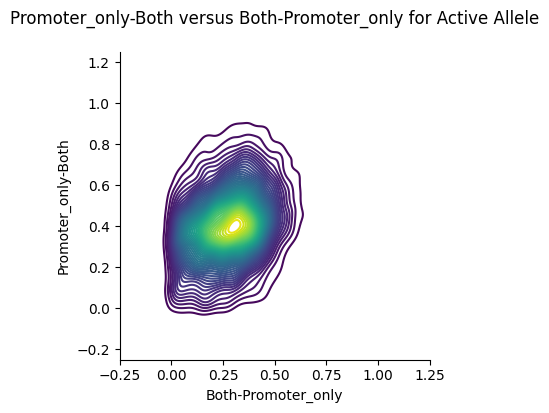

In [6]:
## Example 2D plot of the Promoter only -> Both, vs the Both -> Promoter only kinetics ##
# Below is for the Active allele

x_label = 'Both-Promoter_only'
y_label = 'Promoter_only-Both'
condition = 'Active'
params = {'levels': 50,
          'x_lower': -0.25,
          'x_upper': 1.25,
          'y_lower': -0.25,
          'y_upper': 1.25,
          'save': False}

smm.pl.plot_2D_contour(adata, x_label, y_label, condition, params)

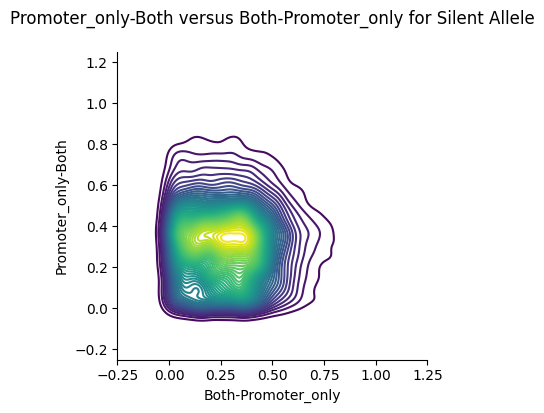

In [7]:
## Example 2D plot of the Promoter only -> Both, vs the Both -> Promoter only kinetics ##
# Below is for the Silent allele

x_label = 'Both-Promoter_only'
y_label = 'Promoter_only-Both'
condition = 'Silent'
params = {'levels': 50,
          'x_lower': -0.25,
          'x_upper': 1.25,
          'y_lower': -0.25,
          'y_upper': 1.25,
          'save': False}

smm.pl.plot_2D_contour(adata, x_label, y_label, condition, params)

In [8]:
columns_to_plot = adata.obs.columns

In [ ]:
# Calculate PCA
sc.tl.pca(adata)
# Calculate neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
# Caclulate UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=columns_to_plot)

In [ ]:
## Plot expression densities on UMAP ##
sc.tl.embedding_density(adata, groupby='condition')
sc.pl.embedding_density(adata, groupby='condition')

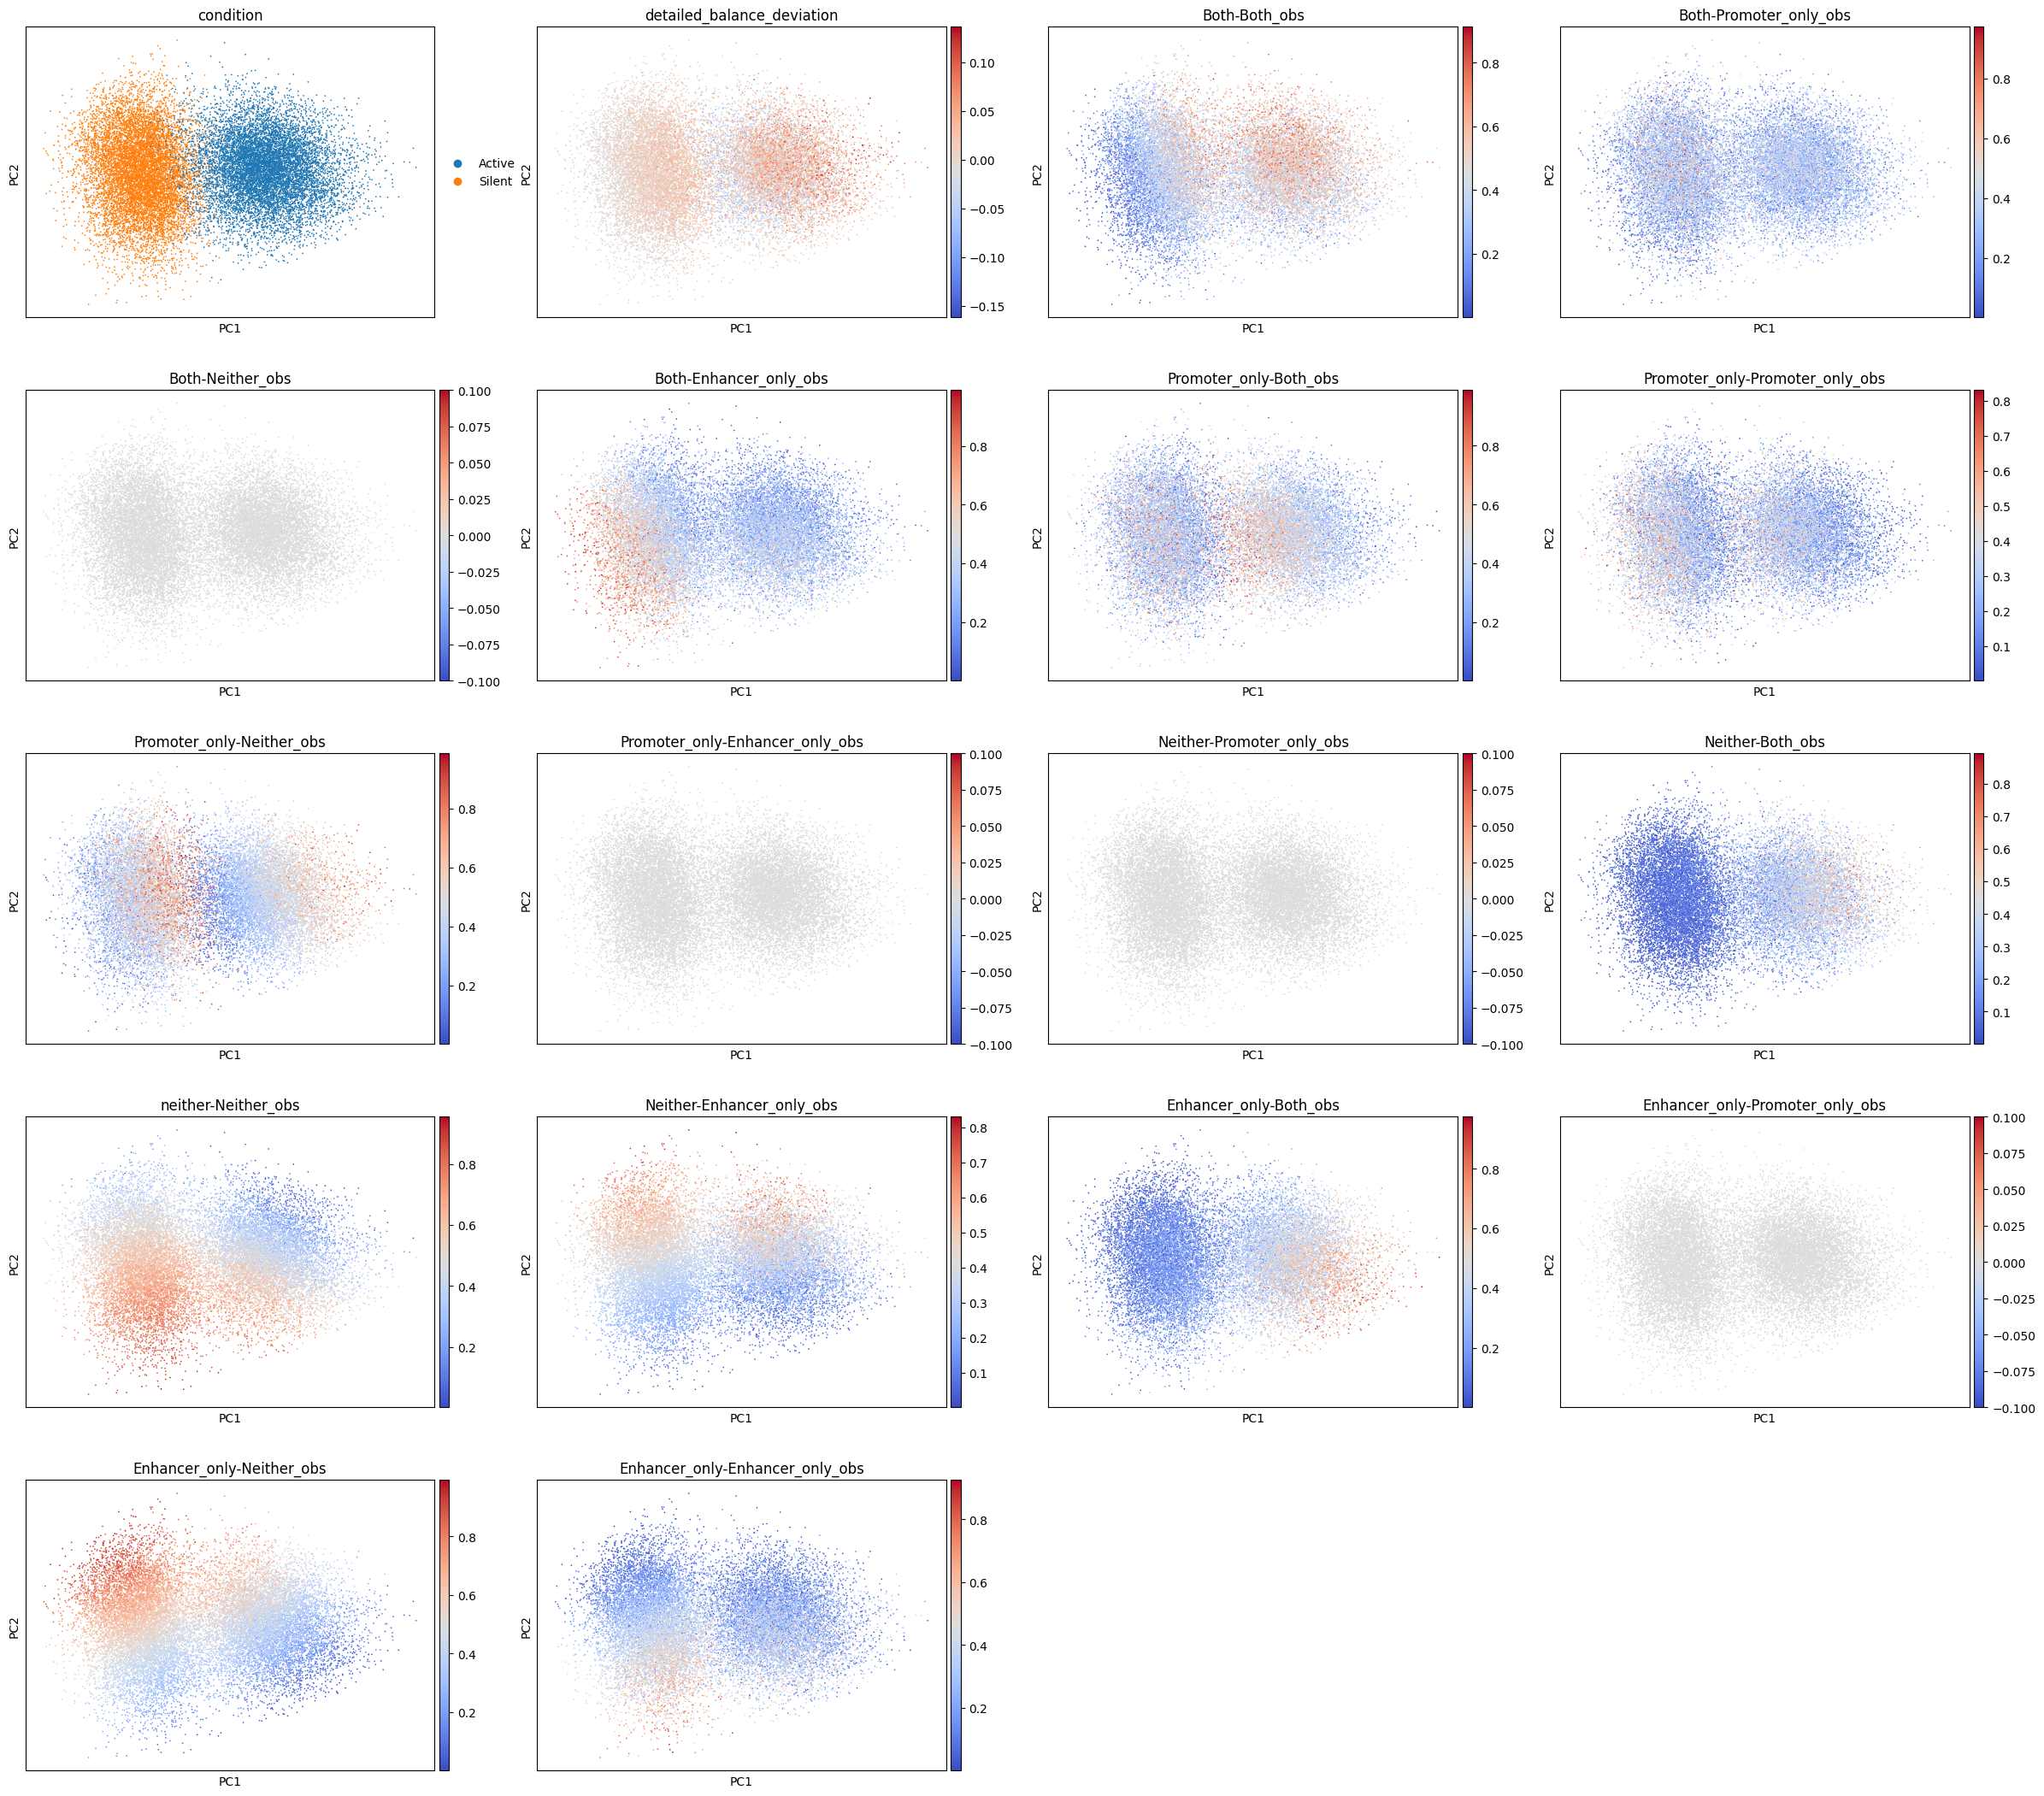

In [9]:
# Calculate PCA
sc.tl.pca(adata)
sc.pl.pca(adata, show=True, color=columns_to_plot, cmap='coolwarm')

In [ ]:
## Plot expression densities on PCA ##
sc.tl.embedding_density(adata, basis='pca', groupby='condition')
sc.pl.embedding_density(adata, basis='pca', groupby='condition', color_map='viridis')

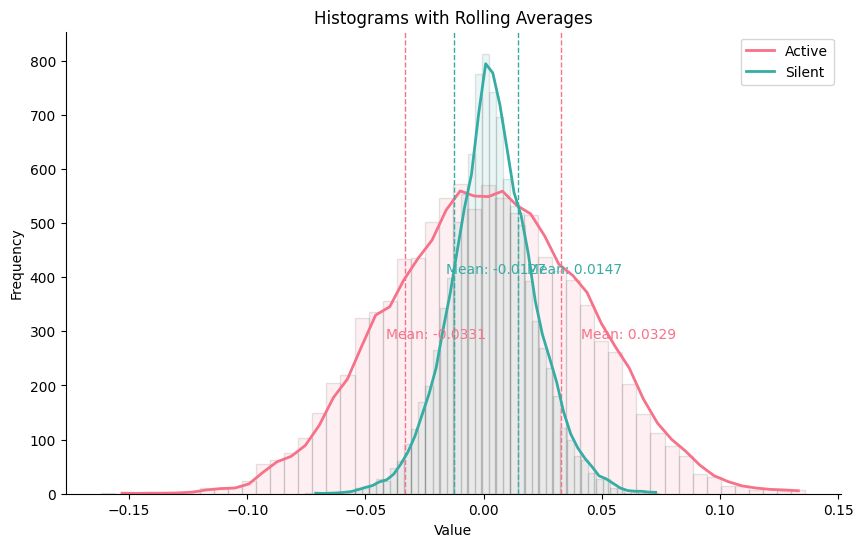

In [11]:
params = {'n_bins': 50,
         'window_size': 2,
         'show_bars': True,
         'show_roll': True,
         'color_palette': 'husl',
         'labels': ['Active', 'Silent'],
          'show_mean': True,
          'show_cdf': False,
         'save': False}

a = adata.uns['Active_allele_detailed_balance_deviations']
b = adata.uns['Silent_allele_detailed_balance_deviations']

smm.pl.plot_hist([a, b], params)